# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [29]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

# 引用依赖包

In [30]:
%config Completer.use_jedi = False

In [31]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## U-Net 网络

In [32]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [33]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [34]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [35]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 565: 


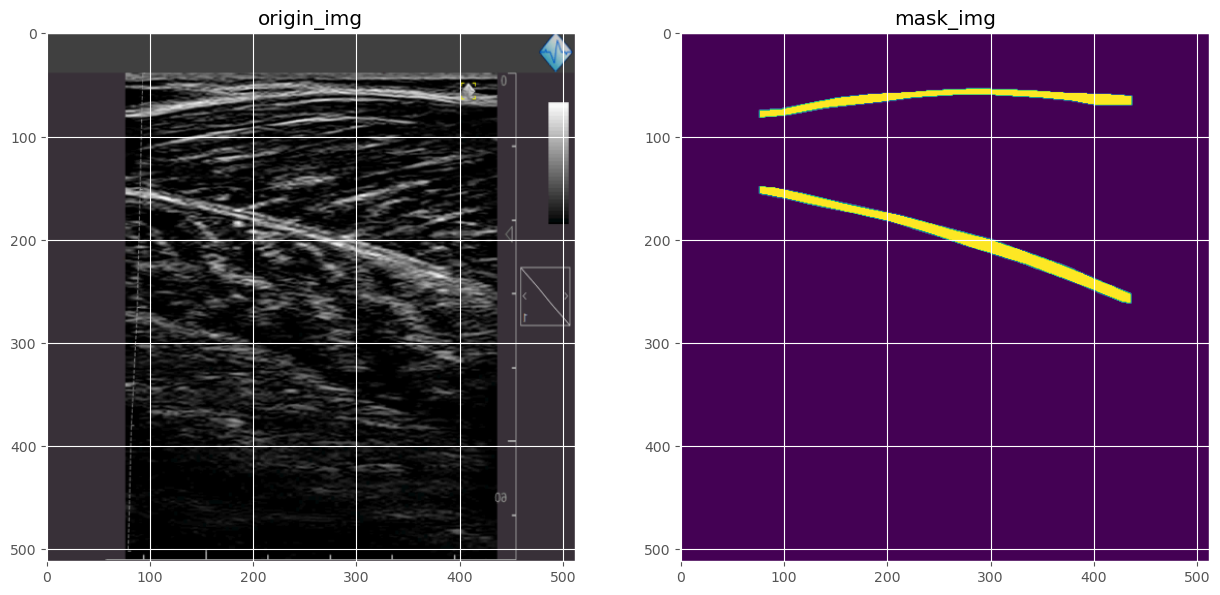

In [36]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [40]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [38]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


In [41]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    
     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    
    train(model, device)

    

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train iou,▁▁▂▂▃▂▄▃▄▅▅█▂▅▃▆▇▅▅▅▇▇▂▆▅▇▄▄▄▆▃▁▂▅▆▅▄▃▂▅
train loss,▇▆▆▅▇▆▅▅▅▅▄▁█▅▇▃▂▇▃▅▃▃▇▄▄▄▇▆▄▄█▇▆▆▅▅▆▆▆▃
epoch,1
step,45
train iou,0.10737
train loss,0.88878


Epoch 1/60:  20%|█▉        | 90/456 [00:37<02:31,  2.42img/s, loss (batch)=0.887]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.96batch/s]


Validation dice_score: 2.823939561843872, IoU Score 0.2175210565328598


Epoch 1/60:  39%|███▉      | 180/456 [01:23<01:54,  2.41img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.96batch/s]


Validation dice_score: 2.6066462993621826, IoU Score 0.18399754166603088


Epoch 1/60:  59%|█████▉    | 270/456 [02:10<01:18,  2.38img/s, loss (batch)=0.845]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.26batch/s]


Validation dice_score: 2.3263580799102783, IoU Score 0.24511362612247467


Epoch 1/60:  79%|███████▉  | 360/456 [02:56<00:40,  2.38img/s, loss (batch)=0.901]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.950658917427063, IoU Score 0.3888015151023865


Epoch 1/60:  99%|█████████▊| 450/456 [03:42<00:02,  2.35img/s, loss (batch)=0.804]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.29batch/s]


Validation dice_score: 1.8280627727508545, IoU Score 0.4572815001010895


Epoch 2/60:  18%|█▊        | 84/456 [00:35<02:36,  2.38img/s, loss (batch)=0.784]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.21batch/s]


Validation dice_score: 1.7231836318969727, IoU Score 0.49998050928115845


Epoch 2/60:  38%|███▊      | 174/456 [01:21<01:59,  2.36img/s, loss (batch)=0.777]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.29batch/s]


Validation dice_score: 1.7252005338668823, IoU Score 0.45669811964035034


Epoch 2/60:  58%|█████▊    | 264/456 [02:08<01:20,  2.39img/s, loss (batch)=0.69] 

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.17batch/s]


Validation dice_score: 1.818037509918213, IoU Score 0.39250558614730835


Epoch 2/60:  78%|███████▊  | 354/456 [02:54<00:42,  2.38img/s, loss (batch)=0.64] 

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.84batch/s]


Validation dice_score: 1.711046576499939, IoU Score 0.454086571931839


Epoch 2/60:  97%|█████████▋| 444/456 [03:40<00:05,  2.39img/s, loss (batch)=0.734]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.6784995794296265, IoU Score 0.46499037742614746


Epoch 3/60:  17%|█▋        | 78/456 [00:32<02:39,  2.37img/s, loss (batch)=0.781]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.01batch/s]


Validation dice_score: 1.7140108346939087, IoU Score 0.429550439119339


Epoch 3/60:  37%|███▋      | 168/456 [01:18<02:01,  2.38img/s, loss (batch)=0.787]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.6213921308517456, IoU Score 0.4787450134754181


Epoch 3/60:  57%|█████▋    | 258/456 [02:04<01:23,  2.36img/s, loss (batch)=0.736]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.5656863451004028, IoU Score 0.5034845471382141


Epoch 3/60:  76%|███████▋  | 348/456 [02:51<00:45,  2.36img/s, loss (batch)=0.828]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.35batch/s]


Validation dice_score: 1.5619796514511108, IoU Score 0.5336944460868835


Epoch 3/60:  96%|█████████▌| 438/456 [03:37<00:07,  2.39img/s, loss (batch)=0.73] 

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.29batch/s]


Validation dice_score: 1.565280795097351, IoU Score 0.49199146032333374


Epoch 4/60:  16%|█▌        | 72/456 [00:30<02:39,  2.41img/s, loss (batch)=0.545]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.31batch/s]


Validation dice_score: 1.5235111713409424, IoU Score 0.5104600787162781


Epoch 4/60:  36%|███▌      | 162/456 [01:16<02:03,  2.38img/s, loss (batch)=0.766]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.35batch/s]


Validation dice_score: 1.5003854036331177, IoU Score 0.5507286190986633


Epoch 4/60:  55%|█████▌    | 252/456 [02:02<01:25,  2.38img/s, loss (batch)=0.653]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.02batch/s]


Validation dice_score: 1.4736220836639404, IoU Score 0.5558308959007263


Epoch 4/60:  75%|███████▌  | 342/456 [02:49<00:48,  2.37img/s, loss (batch)=0.732]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.34batch/s]


Validation dice_score: 1.4833617210388184, IoU Score 0.5168747305870056


Epoch 4/60:  95%|█████████▍| 432/456 [03:35<00:09,  2.40img/s, loss (batch)=0.567]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.93batch/s]


Validation dice_score: 1.4499047994613647, IoU Score 0.534967303276062


Epoch 5/60:  14%|█▍        | 66/456 [00:27<02:43,  2.39img/s, loss (batch)=0.624]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.39batch/s]


Validation dice_score: 1.4183300733566284, IoU Score 0.5513005256652832


Epoch 5/60:  34%|███▍      | 156/456 [01:13<02:04,  2.41img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.3831230401992798, IoU Score 0.5793048143386841


Epoch 5/60:  54%|█████▍    | 246/456 [01:59<01:28,  2.37img/s, loss (batch)=0.623]

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.50batch/s]


Validation dice_score: 1.420662760734558, IoU Score 0.5389876961708069


Epoch 5/60:  74%|███████▎  | 336/456 [02:45<00:50,  2.38img/s, loss (batch)=0.623]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.4128705263137817, IoU Score 0.5387976169586182


Epoch 5/60:  93%|█████████▎| 426/456 [03:31<00:12,  2.38img/s, loss (batch)=0.579]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.370929479598999, IoU Score 0.5911844372749329


Epoch 6/60:  13%|█▎        | 60/456 [00:25<02:44,  2.41img/s, loss (batch)=0.687]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.3476006984710693, IoU Score 0.6012580990791321


Epoch 6/60:  33%|███▎      | 150/456 [01:11<02:06,  2.41img/s, loss (batch)=0.561]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.01batch/s]


Validation dice_score: 1.3524044752120972, IoU Score 0.5920790433883667


Epoch 6/60:  53%|█████▎    | 240/456 [01:57<01:30,  2.38img/s, loss (batch)=0.634]

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.46batch/s]


Validation dice_score: 1.3338788747787476, IoU Score 0.59327232837677


Epoch 6/60:  72%|███████▏  | 330/456 [02:43<00:52,  2.38img/s, loss (batch)=0.738]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.15batch/s]


Validation dice_score: 1.3335729837417603, IoU Score 0.5772047638893127


Epoch 6/60:  92%|█████████▏| 420/456 [03:29<00:15,  2.39img/s, loss (batch)=0.723]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.40batch/s]


Validation dice_score: 1.3279361724853516, IoU Score 0.5916191935539246


Epoch 7/60:  12%|█▏        | 54/456 [00:22<02:48,  2.39img/s, loss (batch)=0.704]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.37batch/s]


Validation dice_score: 1.3381588459014893, IoU Score 0.5462012887001038


Epoch 7/60:  32%|███▏      | 144/456 [01:09<02:12,  2.35img/s, loss (batch)=0.717]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.36batch/s]


Validation dice_score: 1.2904237508773804, IoU Score 0.5993425250053406


Epoch 7/60:  51%|█████▏    | 234/456 [01:55<01:33,  2.39img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.32batch/s]


Validation dice_score: 1.2920624017715454, IoU Score 0.5846897959709167


Epoch 7/60:  71%|███████   | 324/456 [02:41<00:55,  2.37img/s, loss (batch)=0.739]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.17batch/s]


Validation dice_score: 1.245676875114441, IoU Score 0.6028278470039368


Epoch 7/60:  91%|█████████ | 414/456 [03:27<00:17,  2.40img/s, loss (batch)=0.507]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.35batch/s]


Validation dice_score: 1.2549874782562256, IoU Score 0.6064386367797852


Epoch 8/60:  11%|█         | 48/456 [00:20<02:51,  2.38img/s, loss (batch)=0.688]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.85batch/s]


Validation dice_score: 1.2399235963821411, IoU Score 0.611346423625946


Epoch 8/60:  30%|███       | 138/456 [01:06<02:11,  2.42img/s, loss (batch)=0.624]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.230069875717163, IoU Score 0.6055982112884521


Epoch 8/60:  50%|█████     | 228/456 [01:52<01:36,  2.35img/s, loss (batch)=0.723]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.12batch/s]


Validation dice_score: 1.2387818098068237, IoU Score 0.5839374661445618


Epoch 8/60:  70%|██████▉   | 318/456 [02:38<00:57,  2.38img/s, loss (batch)=0.631]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.35batch/s]


Validation dice_score: 1.2148234844207764, IoU Score 0.596551775932312


Epoch 8/60:  89%|████████▉ | 408/456 [03:24<00:20,  2.38img/s, loss (batch)=0.595]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.39batch/s]


Validation dice_score: 1.214044451713562, IoU Score 0.5897338390350342


Epoch 9/60:   9%|▉         | 42/456 [00:17<02:55,  2.36img/s, loss (batch)=0.547]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.2129281759262085, IoU Score 0.6195318698883057


Epoch 9/60:  29%|██▉       | 132/456 [01:03<02:16,  2.37img/s, loss (batch)=0.674]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.38batch/s]


Validation dice_score: 1.1943230628967285, IoU Score 0.6010111570358276


Epoch 9/60:  49%|████▊     | 222/456 [01:49<01:37,  2.40img/s, loss (batch)=0.544]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.30batch/s]


Validation dice_score: 1.1863664388656616, IoU Score 0.6120764017105103


Epoch 9/60:  68%|██████▊   | 312/456 [02:36<01:00,  2.38img/s, loss (batch)=0.616]

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.48batch/s]


Validation dice_score: 1.1974667310714722, IoU Score 0.602180540561676


Epoch 9/60:  88%|████████▊ | 402/456 [03:22<00:22,  2.39img/s, loss (batch)=0.569]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.94batch/s]


Validation dice_score: 1.1932117938995361, IoU Score 0.5981259346008301


Epoch 10/60:   8%|▊         | 36/456 [00:15<02:56,  2.37img/s, loss (batch)=0.791]

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.46batch/s]


Validation dice_score: 1.2034921646118164, IoU Score 0.5797083973884583


Epoch 10/60:  28%|██▊       | 126/456 [01:01<02:19,  2.37img/s, loss (batch)=0.692]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.30batch/s]


Validation dice_score: 1.1576145887374878, IoU Score 0.6232122778892517


Epoch 10/60:  47%|████▋     | 216/456 [01:47<01:39,  2.42img/s, loss (batch)=0.538]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.26batch/s]


Validation dice_score: 1.131008505821228, IoU Score 0.6302480101585388


Epoch 10/60:  67%|██████▋   | 306/456 [02:33<01:03,  2.37img/s, loss (batch)=0.504]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.37batch/s]


Validation dice_score: 1.1635968685150146, IoU Score 0.603225588798523


Epoch 10/60:  87%|████████▋ | 396/456 [03:19<00:25,  2.39img/s, loss (batch)=0.468]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.32batch/s]


Validation dice_score: 1.1282762289047241, IoU Score 0.6067647337913513


Epoch 11/60:   7%|▋         | 30/456 [00:12<02:59,  2.38img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.44batch/s]


Validation dice_score: 1.1271450519561768, IoU Score 0.6079017519950867


Epoch 11/60:  26%|██▋       | 120/456 [00:58<02:21,  2.38img/s, loss (batch)=0.551]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.16batch/s]


Validation dice_score: 1.1175349950790405, IoU Score 0.620376467704773


Epoch 11/60:  46%|████▌     | 210/456 [01:45<01:42,  2.40img/s, loss (batch)=0.785]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.36batch/s]


Validation dice_score: 1.098131537437439, IoU Score 0.6319485306739807


Epoch 11/60:  66%|██████▌   | 300/456 [02:31<01:05,  2.39img/s, loss (batch)=0.657]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.01batch/s]


Validation dice_score: 1.0904858112335205, IoU Score 0.6275529861450195


Epoch 11/60:  86%|████████▌ | 390/456 [03:17<00:27,  2.37img/s, loss (batch)=0.604]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.34batch/s]


Validation dice_score: 1.1094063520431519, IoU Score 0.6102921366691589


Epoch 12/60:   5%|▌         | 24/456 [00:10<03:01,  2.39img/s, loss (batch)=0.657]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.41batch/s]


Validation dice_score: 1.0828430652618408, IoU Score 0.6245120763778687


Epoch 12/60:  25%|██▌       | 114/456 [00:56<02:24,  2.36img/s, loss (batch)=0.65] 

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.48batch/s]


Validation dice_score: 1.0627515316009521, IoU Score 0.6379470825195312


Epoch 12/60:  45%|████▍     | 204/456 [01:42<01:46,  2.36img/s, loss (batch)=0.656]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.72batch/s]


Validation dice_score: 1.0727168321609497, IoU Score 0.6073833107948303


Epoch 12/60:  64%|██████▍   | 294/456 [02:28<01:09,  2.33img/s, loss (batch)=0.693]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.40batch/s]


Validation dice_score: 1.0654367208480835, IoU Score 0.5950766205787659


Epoch 12/60:  84%|████████▍ | 384/456 [03:14<00:29,  2.41img/s, loss (batch)=0.442]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.91batch/s]


Validation dice_score: 1.0247024297714233, IoU Score 0.6540781855583191


Epoch 13/60:   4%|▍         | 18/456 [00:07<03:05,  2.36img/s, loss (batch)=0.67] 

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.10batch/s]


Validation dice_score: 1.0576626062393188, IoU Score 0.6183329224586487


Epoch 13/60:  24%|██▎       | 108/456 [00:54<02:25,  2.39img/s, loss (batch)=0.539]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.37batch/s]


Validation dice_score: 1.0215280055999756, IoU Score 0.6297171711921692


Epoch 13/60:  43%|████▎     | 198/456 [01:40<01:48,  2.39img/s, loss (batch)=0.534]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.96batch/s]


Validation dice_score: 1.005084753036499, IoU Score 0.6347596645355225


Epoch 13/60:  63%|██████▎   | 288/456 [02:26<01:10,  2.38img/s, loss (batch)=0.674]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.34batch/s]


Validation dice_score: 0.9747865200042725, IoU Score 0.6463324427604675


Epoch 13/60:  83%|████████▎ | 378/456 [03:12<00:32,  2.38img/s, loss (batch)=0.51] 

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.26batch/s]


Validation dice_score: 1.0349446535110474, IoU Score 0.5972247123718262


Epoch 14/60:   3%|▎         | 12/456 [00:05<03:07,  2.37img/s, loss (batch)=0.675]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.42batch/s]


Validation dice_score: 1.004980444908142, IoU Score 0.6224905252456665


Epoch 14/60:  22%|██▏       | 102/456 [00:51<02:27,  2.40img/s, loss (batch)=0.499]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.41batch/s]


Validation dice_score: 1.0171103477478027, IoU Score 0.6234579682350159


Epoch 14/60:  42%|████▏     | 192/456 [01:37<01:51,  2.36img/s, loss (batch)=0.567]

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 16.33batch/s]


Validation dice_score: 1.0036797523498535, IoU Score 0.6260395646095276


Epoch 14/60:  62%|██████▏   | 282/456 [02:23<01:13,  2.37img/s, loss (batch)=0.6]  

Validation round


Validation round: 100%|██████████| 115/115 [00:06<00:00, 16.43batch/s]


Validation dice_score: 0.986788809299469, IoU Score 0.6397050619125366


Epoch 14/60:  82%|████████▏ | 372/456 [03:09<00:35,  2.40img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:07<00:00, 15.99batch/s]


Validation dice_score: 0.9546043276786804, IoU Score 0.6315228343009949


Epoch 14/60:  89%|████████▉ | 408/456 [03:33<00:25,  1.91img/s, loss (batch)=0.583]


KeyboardInterrupt: 

# 推理